<a href="https://colab.research.google.com/github/runtorain/GenerativeDeepLearning/blob/main/03_VAE_AutoEndcoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install torchinfo

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [20]:
# Parameters
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
EMBEDDING_DIM = 2
EPOCHS = 20

In [21]:
# Data Preparation
transform = transforms.Compose([
    transforms.Pad(2),
    transforms.ToTensor(),
])

In [22]:
train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [23]:
print(train_dataset[0])

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 9)


In [24]:
train_dataset[0][0].shape

torch.Size([1, 32, 32])

In [25]:
sample_train_dataset = datasets.FashionMNIST(root="./data", train=True)

In [26]:
sample_train_dataset[0]

(<PIL.Image.Image image mode=L size=28x28>, 9)

In [27]:
sample_train_dataset[0][0]

In [28]:
from torchvision.transforms import ToTensor

# Example PIL image from the dataset
image, label = sample_train_dataset[0]

# Convert to PyTorch tensor
tensor_image = ToTensor()(image)

print(tensor_image.shape)  # Output: torch.Size([1, 28, 28])
print(tensor_image)

torch.Size([1, 28, 28])
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000,

In [34]:
# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(CHANNELS, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

        self.flatten = nn.Flatten()
        self.fc_encode = nn.Linear(128 * 4 * 4, EMBEDDING_DIM)

        # Decoder
        self.fc_decode = nn.Linear(EMBEDDING_DIM, 128 * 4 * 4)
        self.unflatten = nn.Unflatten(1, (128, 4, 4))

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, CHANNELS, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        z = self.fc_encode(x)
        x = self.fc_decode(z)
        x = self.unflatten(x)
        x = self.decoder(x)
        return x, z

In [35]:
# Model Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [36]:
from torchinfo import summary

# Print model summary
summary(model, input_size=(BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [100, 1, 32, 32]          --
├─Sequential: 1-1                        [100, 128, 4, 4]          --
│    └─Conv2d: 2-1                       [100, 32, 16, 16]         320
│    └─ReLU: 2-2                         [100, 32, 16, 16]         --
│    └─Conv2d: 2-3                       [100, 64, 8, 8]           18,496
│    └─ReLU: 2-4                         [100, 64, 8, 8]           --
│    └─Conv2d: 2-5                       [100, 128, 4, 4]          73,856
│    └─ReLU: 2-6                         [100, 128, 4, 4]          --
├─Flatten: 1-2                           [100, 2048]               --
├─Linear: 1-3                            [100, 2]                  4,098
├─Linear: 1-4                            [100, 2048]               6,144
├─Unflatten: 1-5                         [100, 128, 4, 4]          --
├─Sequential: 1-6                        [100, 1, 32, 32]          --


In [37]:
import time

def train_model():
    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0
        start_time = time.time()  # Record the start time

        for images, _ in train_loader:
            images = images.to(device)

            # Forward pass
            reconstructed, _ = model(images)
            loss = criterion(reconstructed, images)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Calculate epoch duration
        end_time = time.time()
        epoch_duration = end_time - start_time

        print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {total_loss / len(train_loader):.4f}, Time: {epoch_duration:.2f} seconds")

def evaluate_model(loader):
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            reconstructed, embeddings = model(images)
            return images.cpu(), reconstructed.cpu(), embeddings.cpu()


In [38]:
# Train the model
train_model()

Epoch 1/20, Loss: 0.2948, Time: 12.69 seconds
Epoch 2/20, Loss: 0.2621, Time: 12.35 seconds
Epoch 3/20, Loss: 0.2576, Time: 12.38 seconds
Epoch 4/20, Loss: 0.2551, Time: 12.39 seconds
Epoch 5/20, Loss: 0.2534, Time: 17.43 seconds
Epoch 6/20, Loss: 0.2524, Time: 12.04 seconds
Epoch 7/20, Loss: 0.2514, Time: 12.24 seconds
Epoch 8/20, Loss: 0.2505, Time: 12.29 seconds
Epoch 9/20, Loss: 0.2499, Time: 11.98 seconds
Epoch 10/20, Loss: 0.2493, Time: 12.94 seconds
Epoch 11/20, Loss: 0.2490, Time: 12.11 seconds
Epoch 12/20, Loss: 0.2484, Time: 11.96 seconds
Epoch 13/20, Loss: 0.2480, Time: 12.52 seconds
Epoch 14/20, Loss: 0.2476, Time: 12.77 seconds
Epoch 15/20, Loss: 0.2473, Time: 12.35 seconds
Epoch 16/20, Loss: 0.2472, Time: 12.09 seconds
Epoch 17/20, Loss: 0.2467, Time: 11.91 seconds
Epoch 18/20, Loss: 0.2467, Time: 11.89 seconds
Epoch 19/20, Loss: 0.2463, Time: 11.96 seconds
Epoch 20/20, Loss: 0.2461, Time: 11.90 seconds


In [39]:
# Evaluate and Visualize
example_images, reconstructed_images, embeddings = evaluate_model(test_loader)

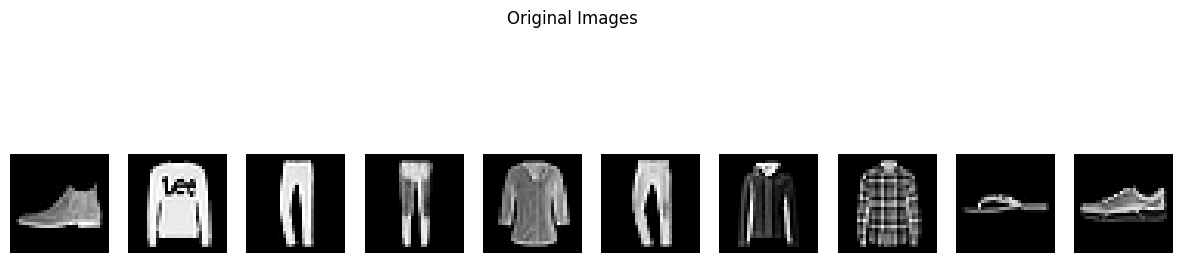

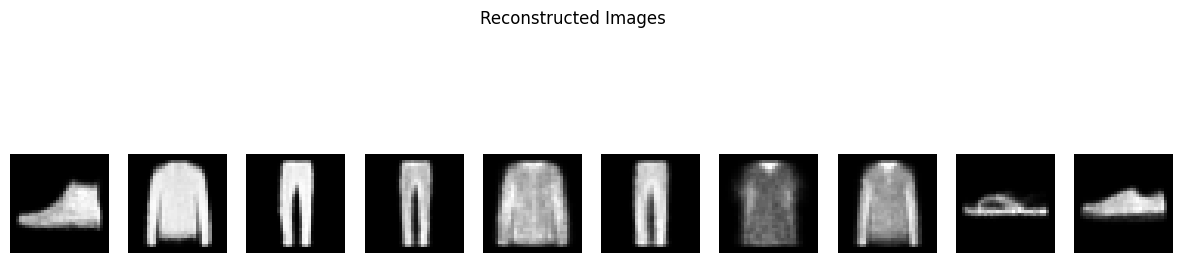

In [40]:
# Visualize Original and Reconstructed Images
def display(images, title):
    fig, axes = plt.subplots(1, 10, figsize=(15, 4))
    for i, ax in enumerate(axes):
        ax.imshow(images[i].squeeze(), cmap="gray")
        ax.axis("off")
    plt.suptitle(title)
    plt.show()

display(example_images[:10], "Original Images")
display(reconstructed_images[:10], "Reconstructed Images")

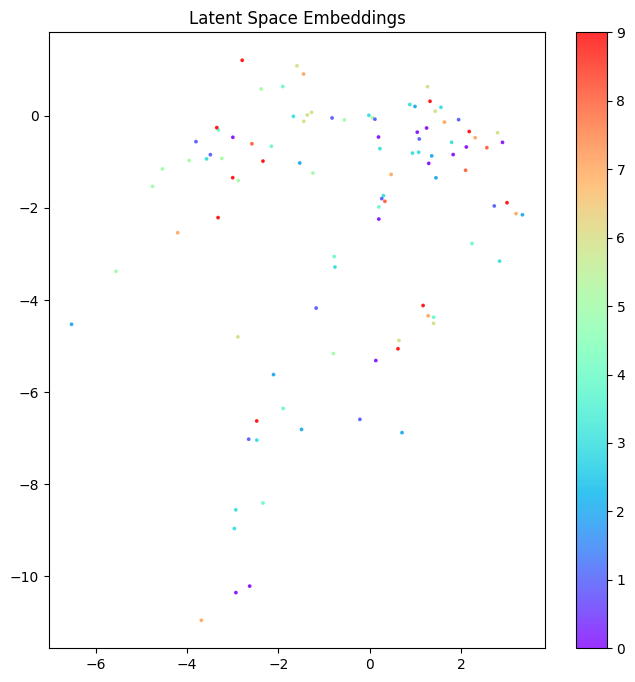

In [41]:
# Visualize Embeddings
plt.figure(figsize=(8, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=train_dataset.targets[:len(embeddings)], cmap="rainbow", s=3, alpha=0.8)
plt.colorbar()
plt.title("Latent Space Embeddings")
plt.show()


In [42]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image

# Get the dataset from the DataLoader
dataset = train_loader.dataset

# Specify which image you want
image_index = 10  # Index of the desired image in the dataset
image, label = dataset[image_index]  # Access the image and its label


In [43]:
label

0

In [44]:
image

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

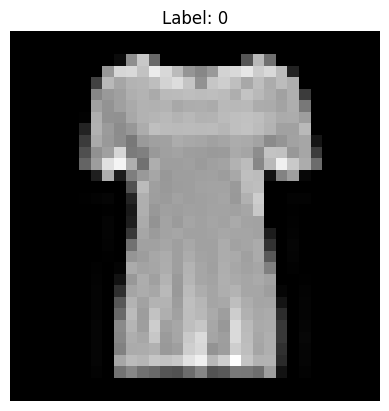

In [45]:
# Convert the tensor to a PIL image (undo normalization if necessary)
to_pil = transforms.ToPILImage()
pil_image = to_pil(image)

# Display the image
plt.imshow(pil_image, cmap="gray")
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()


In [46]:
# Save the image to a file
pil_image.save(f"image_{image_index}_label_{label}.png")
print(f"Image saved as image_{image_index}_label_{label}.png")

Image saved as image_10_label_0.png


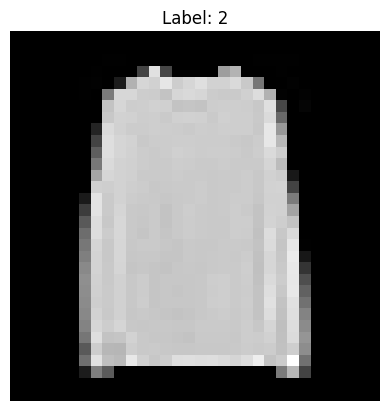

In [47]:
for batch_idx, (images, labels) in enumerate(train_loader):
    specific_image = images[5]  # Select the 5th image in this batch
    specific_label = labels[5]  # Get the corresponding label
    break  # Exit after extracting the first batch

# Convert to a PIL image
pil_image = to_pil(specific_image)

# Display and save
plt.imshow(pil_image, cmap="gray")
plt.title(f"Label: {specific_label}")
plt.axis("off")
plt.show()

# Save the image
pil_image.save(f"specific_image_label_{specific_label}.png")


In [48]:
train_dataset[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 9)

In [50]:
# Extract the first image
image = train_dataset[0][0]

# Prepare the image
image_tensor = image.unsqueeze(0).to(device)  # Add batch dimension and send to device

# Generate the embedding
model.eval()
with torch.no_grad():
    _,embedding = model(image_tensor)

# Print the embedding
embedding_np = embedding.cpu().numpy()
print("Embedding:", embedding_np)

Embedding: [[-1.0075694   0.95600724]]


In [52]:
train_dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Pad(padding=2, fill=0, padding_mode=constant)
               ToTensor()
           )

In [62]:
for i in range(10):
    print(train_dataset[i][1])

9
0
0
3
0
2
7
2
5
5


In [66]:
def endcoding_reading(image):
  # Prepare the image
  image_tensor = image.unsqueeze(0).to(device)  # Add batch dimension and send to device

  # Generate the embedding
  model.eval()
  with torch.no_grad():
      _,embedding = model(image_tensor)

  # Print the embedding
  embedding_np = embedding.cpu().numpy()
  print("Embedding:", embedding_np)

  return embedding_np

In [64]:
endcoding_reading(train_dataset[1][0])

Embedding: [[ 1.6021552 -3.767724 ]]


In [65]:
endcoding_reading(train_dataset[2][0])

Embedding: [[-0.66035885 -3.393551  ]]


In [67]:
a = endcoding_reading(train_dataset[1][0])
b = endcoding_reading(train_dataset[2][0])

Embedding: [[ 1.6021552 -3.767724 ]]
Embedding: [[-0.66035885 -3.393551  ]]


In [69]:
a,b

(array([[ 1.6021552, -3.767724 ]], dtype=float32),
 array([[-0.66035885, -3.393551  ]], dtype=float32))

In [71]:
# Flatten the arrays to 1D
a_flat = a.flatten()
b_flat = b.flatten()

# Compute cosine similarity
cosine_similarity = np.dot(a_flat, b_flat) / (np.linalg.norm(a_flat) * np.linalg.norm(b_flat))

print("Cosine Similarity:", cosine_similarity)

Cosine Similarity: 0.8285645


In [72]:
a_flat

array([ 1.6021552, -3.767724 ], dtype=float32)

In [73]:
c = endcoding_reading(train_dataset[0][0])
d = endcoding_reading(train_dataset[1][0])

Embedding: [[-1.0075694   0.95600724]]
Embedding: [[ 1.6021552 -3.767724 ]]


In [75]:
# Flatten the arrays to 1D
c_flat = c.flatten()
d_flat = d.flatten()

# Compute cosine similarity
cosine_similarity = np.dot(c_flat, d_flat) / (np.linalg.norm(c_flat) * np.linalg.norm(d_flat))

print("Cosine Similarity:", cosine_similarity)

Cosine Similarity: -0.91728634
Cosine Similarity: -0.91728634


In [76]:
e = endcoding_reading(train_dataset[8][0])
f = endcoding_reading(train_dataset[9][0])

Embedding: [[-1.2088118 -1.6461768]]
Embedding: [[-0.93040913 -1.0991799 ]]


In [77]:
# Flatten the arrays to 1D
e_flat = e.flatten()
f_flat = f.flatten()

# Compute cosine similarity
cosine_similarity = np.dot(e_flat, f_flat) / (np.linalg.norm(e_flat) * np.linalg.norm(f_flat))

print("Cosine Similarity:", cosine_similarity)

Cosine Similarity: 0.99761724


In [78]:
#1. Euclidean Distance
import numpy as np

# Compute Euclidean distance
euclidean_distance = np.linalg.norm(e_flat - f_flat)

print("Euclidean Distance:", euclidean_distance)


Euclidean Distance: 0.61377007


In [79]:
#1. Euclidean Distance
import numpy as np

# Compute Euclidean distance
euclidean_distance = np.linalg.norm(c_flat - d_flat)

print("Euclidean Distance:", euclidean_distance)

Euclidean Distance: 5.396693


In [80]:
#2. Manhattan Distance (L1 Norm)
# Compute Manhattan distance (L1 norm)
manhattan_distance = np.sum(np.abs(a_flat - b_flat))

print("Manhattan Distance:", manhattan_distance)


Manhattan Distance: 2.636687


## Summary of Similarity Measures:

1.   Cosine Similarity: Measures the angle between two vectors.

2. Euclidean Distance: Measures the straight-line distance between two vectors.
3.   Manhattan Distance: Measures the sum of absolute differences between vectors.
4.   Minkowski Distance: Generalization of Euclidean and Manhattan distances.
5. Dot Product: Measures similarity without normalization (e.g., for unnormalized vectors).
6. Jaccard Similarity: Used for binary data or sets.
7. Pearson Correlation: Measures linear relationship between vectors.